# Cubed sphere grid explanation with Weimer potential

Create a figure explaining the cubed sphere grid. Using the Weimer () potential.

The cubed sphere grid objects have differentiation matrices $\mathbb D_e$, $\mathbb D_n$, as well as a matrix $\mathbb D_{\nabla\cdot}$ which, when applied to a vector field $V$ produces the divergence of $V$. 


Below we:
 1. Set up the cubed sphere grid
 2. Read a Weimer model output file
 3. Get east, north electric fields
 4. Plot
 
Import relevant modules:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import lompe

R = 6371.2e3 # Earth radius
B0 = 3.12e-5 # Mean magnetic field
stencil_size = 3 # size of the stencil used for numerical differentiation

Set up cubed sphere grid:

In [2]:
projection = lompe.cs.CSprojection((0, 90), 0)
grid = lompe.cs.CSgrid(projection, 20000e3, 20000e3, 50e3, 50e3, R = R)
SKIP = 10 # how many grid points to skip when plotting vector fields

Next, read Weimer module output file and calculate $\mathbf v$ on the grid, assuming a dipole magnetic field

In [3]:
# read potential file:
weimer = pd.read_table('./weimer.txt', sep = ' ', skipinitialspace = True, comment = '#', names = ['mlat', 'mlt', 'R_E', 'phi'])
weimer = weimer[weimer.mlat > 0] # remove southern hemisphere

# get lat, lon coordinates, convert to SI-units
latxx = weimer.mlat.values.reshape((181, 61))
lonxx = weimer.mlt. values.reshape((181, 61)) * 15 # mlt to lon
V     = weimer.phi .values.reshape((181, 61)) * 1e3 # kV to V

# interpolate potential to cubedsphere grid:
xi, eta = grid.projection.geo2cube(lonxx, latxx)
V       = griddata((xi.flatten(), eta.flatten()), V.flatten(), (grid.xi.flatten(), grid.eta.flatten()), fill_value = 0, method = 'linear', rescale = True).reshape(grid.shape)

Differentiate $\Phi$ to get electric field components as $\mathbf{E} = -\nabla\Phi$.
\begin{equation*}
    \mathbf{E}_e = \mathbb D_e\cdot\Phi
\end{equation*}
\begin{equation*}
    \mathbf{E}_n = \mathbb D_n\cdot\Phi
\end{equation*}

In [4]:
# use cubedsphere differentiation matrices to get electric field:
De, Dn = grid.get_Le_Ln(S = stencil_size, return_sparse = True)
E_n = -Dn.dot(V.flatten()).reshape(grid.shape)
E_e = -De.dot(V.flatten()).reshape(grid.shape)

Smooth electric field a bit:

In [5]:
E_e = median_filter(E_e, size = 3*SKIP, mode = 'constant', cval = 0)
E_n = median_filter(E_n, size = 3*SKIP, mode = 'constant', cval = 0)

E_n[grid.lat < 60] = 0

$\mathbf{E}$ is a $2N$ element column vector, where $N$ is the number of grid cells. We get the divergence of $\mathbf{E}$:
\begin{equation*}
    \mathbb D_{\nabla^2}\Phi=\nabla\cdot \mathbf{E} = \mathbb D_{\nabla\cdot}\begin{pmatrix}\mathbf{E}_e\\\mathbf{E}_n\end{pmatrix}
\end{equation*}

$\mathbb D_{\nabla\cdot}$ is a $2N\times N$ matrix that operates on $\mathbf{E}$ that has length $2N$

In [6]:
E_mat = np.vstack((E_n, E_e))
# use cubedsphere divergence matrix to get div(E):
Ddiv = grid.divergence(S = stencil_size, return_sparse = True)
divE = Ddiv.dot(E_mat.flatten()).reshape(grid.shape)

In [7]:
xi[::5]

array([[ 0.00000000e+00,  1.06873307e-18,  2.13762894e-18, ...,
         6.78832806e-17,  6.92871822e-17,  7.07050159e-17],
       [-0.00000000e+00, -1.51615351e-03, -3.03253101e-03, ...,
        -9.60063320e-02, -9.79792939e-02, -9.99710588e-02],
       [-0.00000000e+00, -2.98404007e-03, -5.96848153e-03, ...,
        -1.87317362e-01, -1.91098579e-01, -1.94911713e-01],
       ...,
       [ 0.00000000e+00,  2.98404007e-03,  5.96848153e-03, ...,
         1.87317362e-01,  1.91098579e-01,  1.94911713e-01],
       [ 0.00000000e+00,  1.51615351e-03,  3.03253101e-03, ...,
         9.60063320e-02,  9.79792939e-02,  9.99710588e-02],
       [ 0.00000000e+00,  1.06873307e-18,  2.13762894e-18, ...,
         6.78832806e-17,  6.92871822e-17,  7.07050159e-17]])

Set up figure and plot:

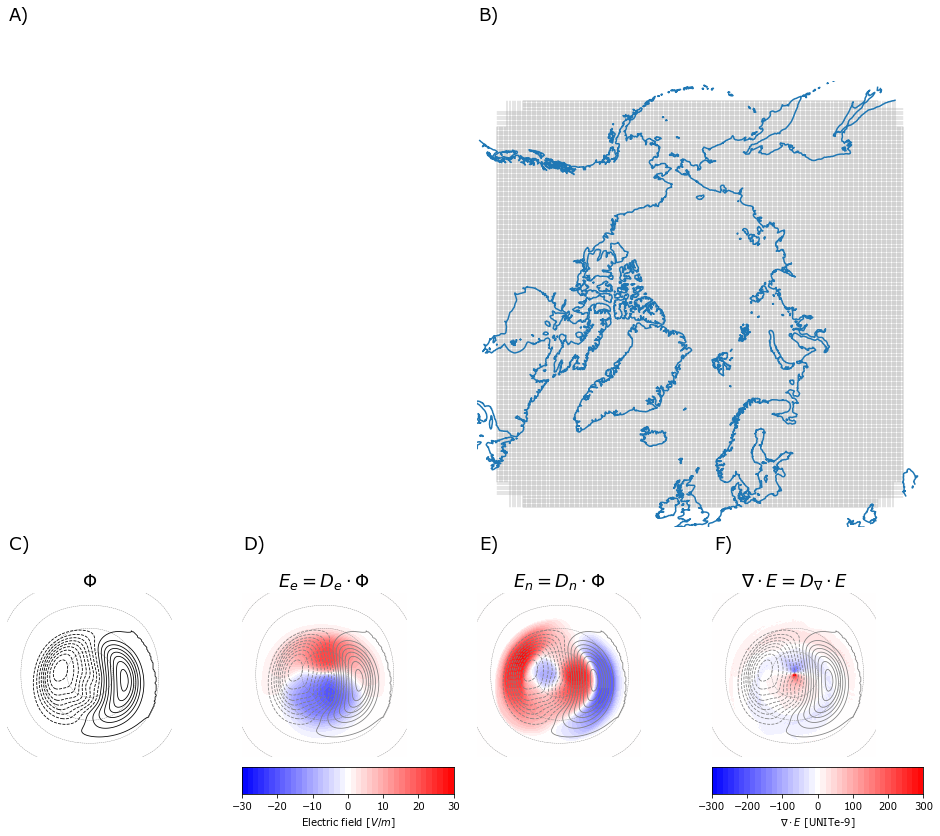

In [89]:
# Start by setting up figure and subplots:
fig = plt.figure(figsize = (12*1.25, 9*1.25))

axs1, axs2 = {}, {} # initialize dictionaries for axes

# upper row
axs1['onsphere' ] = plt.subplot2grid((30, 40), (2,  0), rowspan = 19, colspan = 19)
axs1['grid'     ] = plt.subplot2grid((30, 40), (2, 20), rowspan = 19, colspan = 19)
axs1['label'    ] = plt.subplot2grid((30, 40), (1,  0))
axs1['label2'   ] = plt.subplot2grid((30, 40), (1, 20))

# lower row
axs2['potential'] = plt.subplot2grid((30, 40), (22,  0), rowspan = 7, colspan = 7)
axs2['E_e'      ] = plt.subplot2grid((30, 40), (22, 10), rowspan = 7, colspan = 7)
axs2['E_n'      ] = plt.subplot2grid((30, 40), (22, 20), rowspan = 7, colspan = 7)
axs2['Ediv'     ] = plt.subplot2grid((30, 40), (22, 30), rowspan = 7, colspan = 7)

axs2['label'    ] = plt.subplot2grid((30, 40), (21, 0))
axs2['label2'   ] = plt.subplot2grid((30, 40), (21, 10))
axs2['label3'   ] = plt.subplot2grid((30, 40), (21, 20))
axs2['label4'   ] = plt.subplot2grid((30, 40), (21, 30))

axs2['cbar'     ] = plt.subplot2grid((30, 40), (29, 10), colspan = 9)
axs2['cbar2'    ] = plt.subplot2grid((30, 40), (29, 30), colspan = 9)

plt.subplots_adjust(hspace = 0, wspace = 0, left = 0.05, right = .92, bottom = 0.01 ,top = .99)

# labels:
axs1['label'].set_title( 'A)', fontsize = 18)
axs1['label2'].set_title('B)', fontsize = 18)
axs2['label'].set_title( 'C)', fontsize = 18)
axs2['label2'].set_title('D)', fontsize = 18)
axs2['label3'].set_title('E)', fontsize = 18)
axs2['label4'].set_title('F)', fontsize = 18)

###################### upper row of plots #########################
for key in axs1.keys():
    axs1[key].set_axis_off()
    if 'label' in key:
        continue
    axs1[key].set_aspect('equal')
    
# B) grid on map
for lon, lat in grid.get_grid_boundaries():
    xi, eta = grid.projection.geo2cube(lon, lat)
    axs1['grid'].plot(xi[::10], eta[::10], color = 'grey', linewidth = .4)

# add coastlines
xlim, ylim = axs1['grid'].get_xlim(), axs1['grid'].get_ylim()
for cl in grid.projection.get_projected_coastlines():
    axs1['grid'].plot(cl[0], cl[1], color = 'C0')

axs1['grid'].set_xlim(xlim)
axs1['grid'].set_ylim(ylim)

###################### lower row of plots 

# Set up axis for phi, Ee, En, divE
for key in axs2.keys():
    if 'cbar' in key: 
        continue
    axs2[key].set_axis_off()
    if 'label' in key:
        continue
    axs2[key].set_aspect('equal')
    axs2[key].contour(grid.xi, grid.eta, grid.lat, linestyles = '--', colors = 'grey', linewidths = .4, levels = np.r_[-80:81:10])
    
# f = Phi
axs2['potential'].set_title(r'$\Phi$', fontsize = 18)
axs2['potential'].contour(grid.xi, grid.eta, V, colors = 'black', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)

# color scale for east, north E-field
Elevels = np.linspace(-30, 30, 40) * 1e-3

# E_e = D_e * Phi
axs2['E_e'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['E_e'].contourf(grid.xi, grid.eta, E_e, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_e'].set_title(r'$E_e = D_e \cdot \Phi$', fontsize = 18)

# E_n = D_n * Phi
axs2['E_n'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['E_n'].contourf(grid.xi, grid.eta, E_n, cmap = plt.cm.bwr, levels = Elevels)
axs2['E_n'].set_title(r'$E_n = D_n \cdot \Phi$', fontsize = 18)

# color bar for east, north electric fields
x = np.vstack((Elevels, Elevels)).T
y = np.vstack((np.zeros(Elevels.size), np.ones(Elevels.size))).T
axs2['cbar'].contourf(x*1e3, y, x*1e3, levels = Elevels*1e3, cmap = plt.cm.bwr)
axs2['cbar'].set_yticks([])
axs2['cbar'].xaxis.set_label_position("bottom")
axs2['cbar'].xaxis.tick_bottom()
axs2['cbar'].set_xlabel('Electric field [$V/m$]')

# color scale for divergence of E-field
divElevels = np.linspace(-300, 300, 40) * 1e-9 

# E_div = D_div * E
axs2['Ediv'].contour(grid.xi, grid.eta, V, colors = 'gray', levels = np.r_[-100:101:4] * 1e3, linewidths = .8)
axs2['Ediv'].contourf(grid.xi, grid.eta, divE, cmap = plt.cm.bwr, levels = divElevels)
axs2['Ediv'].set_title(r'$\nabla \cdot E = D_{\nabla} \cdot E$', fontsize = 18);

# color bar for div(E)
x = np.vstack((divElevels, divElevels)).T
y = np.vstack((np.zeros(divElevels.size), np.ones(divElevels.size))).T
axs2['cbar2'].contourf(x*1e9, y, x*1e9, levels = divElevels*1e9, cmap = plt.cm.bwr)
axs2['cbar2'].set_yticks([])
axs2['cbar2'].xaxis.set_label_position("bottom")
axs2['cbar2'].xaxis.tick_bottom()
axs2['cbar2'].set_xlabel(r'$\nabla\cdot E$ [UNITe-9]');
